In [ ]:
#Reference : https://www.tensorflow.org/tutorials/text/nmt_with_attention

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [2]:
%pip install wandb -q
import wandb

     |████████████████████████████████| 1.8MB 7.6MB/s 
     |████████████████████████████████| 102kB 14.0MB/s 
     |████████████████████████████████| 174kB 26.8MB/s 
     |████████████████████████████████| 133kB 47.6MB/s 
     |████████████████████████████████| 71kB 9.7MB/s 


In [3]:
sweep_config = {
    'method': 'bayes', #grid, random
    'metric': {
      'name': 'val_acc',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs':{
          'values':[1]  
        },
        #embedding
        'embedding': {
            'values': [16,32,64,256]
        },
        'hidden': {
            'values': [64, 256,512,1024]
        },
        #100% means no fine tuning, only pre training
        'cell':{
            'values': ['rnn','gru','lstm']
        
        },
        'dropout': {
            'values':[0,0.2,0.3]
        },
        'batch_size':{
            'values':[32,64]
        }

    }
}

In [4]:
sweep_id = wandb.sweep(sweep_config,entity='aeaswar81', project="cs6910-assignment3-testing") 

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: n4sb0ptm
Sweep URL: https://wandb.ai/aeaswar81/cs6910-assignment3-testing/sweeps/n4sb0ptm


In [5]:
from matplotlib.font_manager import FontProperties
hindi_font = FontProperties(fname = 'Nirmala.ttf')

In [6]:
!wget https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
!tar -xvf 'dakshina_dataset_v1.0.tar'

--2021-05-17 05:11:35--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c00::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G  27.3MB/s    in 18s     

2021-05-17 05:11:53 (108 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]

dakshina_dataset_v1.0/bn/
dakshina_dataset_v1.0/bn/lexicons/
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.dev.tsv
dakshina_dataset_v1.0/bn/native_script_wikipedia/
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.valid.text.shu

In [9]:
train_hindi_path = "/content/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
val_hindi_path="/content/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv"



In [10]:
def create_dataset(path, num_examples):
  input_texts = []
  target_texts = []
  with open(path, "r", encoding="utf-8") as f:
    train_lines = f.read().split("\n")
  train_lines.pop()

#go through the train lines and split them into 3 and save input and target 
  for line in train_lines[: min(num_examples,(len(train_lines) - 1))]:
    #because we want english to devanagiri conversion 
    target_text, input_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_text = "\t" +input_text + "\n"
    #append it to the main input texts list
    input_texts.append(input_text)
    #append it to the main target texts list 
    target_texts.append(target_text)
  
  return (input_texts,target_texts)



In [14]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [15]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  inp_lang,targ_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [16]:
# size of the dataset
num_examples = 300000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(train_hindi_path,
                                                                num_examples)
input_tensor_val,target_tensor_val,_,_=load_dataset(val_hindi_path,num_examples)

word_val_input,word_val_target=create_dataset(val_hindi_path, 30000)
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1
BUFFER_SIZE = len(input_tensor)
# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
print(inp_lang.index_word[3])
print(targ_lang.index_word[1])
print(len(input_tensor), len(target_tensor), len(input_tensor_val), len(target_tensor_val))





	
44203 44203 4357 4357


In [17]:
def convert(lang, tensor):
  for t in tensor:
    if t != 0:
      #print(t)
      print(f'{t} ----> {lang.index_word[t]}')


In [18]:
print("Input Language; index to word mapping")
convert(inp_lang, input_tensor[3])
print()
print("Target Language; index to word mapping")
convert(targ_lang, target_tensor[3])


Input Language; index to word mapping
2 ----> 	
1 ----> a
4 ----> n
13 ----> k
15 ----> u
7 ----> r
3 ----> 


Target Language; index to word mapping
1 ----> 	
31 ----> अ
11 ----> ं
8 ----> क
24 ----> ु
4 ----> र
2 ----> 



In [19]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz,cell_type,drop):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.cell_type=cell_type
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.dropout=drop
    if(cell_type=='lstm'):
      self.cell = tf.keras.layers.LSTM(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',dropout=self.dropout)
    elif(cell_type=='gru'):
      self.cell = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',dropout=self.dropout)
    elif(cell_type=='rnn'):
      self.cell = tf.keras.layers.SimpleRNN(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',dropout=self.dropout)

  def call(self, x): #, hidden):
    x = self.embedding(x)
    if(self.cell_type=='lstm'):
      output, state_h,state_c = self.cell(x)#, initial_state=hidden)
      return output, state_h,[state_h,state_c]
    elif(self.cell_type=='gru'):
      output, state = self.cell(x)
      return output, state,state
    elif(self.cell_type=='rnn'):
      output, state = self.cell(x)
      return output, state,state

 # def initialize_hidden_state(self):
  #  dim=tf.zeros([self.batch_sz, self.enc_units])
   # return [dim,dim]


In [20]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [21]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz,cell_type,drop):
    super(Decoder, self).__init__()
    self.cell_type=cell_type
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.dropout=drop
    if(cell_type=='lstm'):
      self.cell = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',dropout=self.dropout)
    elif(cell_type=='gru'):
      self.cell = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',dropout=self.dropout)
    elif(cell_type=='rnn'):
      self.cell = tf.keras.layers.SimpleRNN(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',dropout=self.dropout)


    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output,states):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    if(self.cell_type=='lstm'):
    # passing the concatenated vector to the GRU
      output, state,state_c = self.cell(x,initial_state=states)

    # output shape == (batch_size * 1, hidden_size)
      output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
      x = self.fc(output)

      return x, state,[state,state_c], attention_weights
    elif(self.cell_type=='gru'):
      output, state = self.cell(x,initial_state=states)

    # output shape == (batch_size * 1, hidden_size)
      output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
      x = self.fc(output)

      return x, state, state, attention_weights
    elif(self.cell_type=='rnn'):
      output, state = self.cell(x,initial_state=states)

    # output shape == (batch_size * 1, hidden_size)
      output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
      x = self.fc(output)

      return x, state, state, attention_weights

In [22]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)


In [24]:
def train():
  
  wandb.init()
  config = wandb.config
  n=str(config.cell)+"_hidden"+str(config.hidden)+"_embed"+str(config.embedding)+"_drop"+str(config.dropout)+"_epoch"+str(config.epochs)
  wandb.run.name=n
  BATCH_SIZE = config.batch_size
  steps_per_epoch = len(input_tensor)//BATCH_SIZE
  embedding_dim = config.embedding
  units = config.hidden
  drop=config.dropout
  EPOCHS=config.epochs
  cell=config.cell
  dataset = tf.data.Dataset.from_tensor_slices((input_tensor, target_tensor)).shuffle(BUFFER_SIZE)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

  encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE,cell,drop)
  decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE,cell,drop)
  @tf.function
  def train_step(inp, targ):
    loss = 0
    #print(type(encoder))
    with tf.GradientTape() as tape:
      enc_output, enc_hidden,states = encoder(inp)
      dec_hidden = enc_hidden

      dec_input = tf.expand_dims([targ_lang.word_index['\t']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
      for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
        predictions, dec_hidden, states,_ = decoder(dec_input, dec_hidden, enc_output,states)
      #states=[dec_hidden,enc_c]
        loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
        dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss
  
  for epoch in range(EPOCHS):

    start = time.time()

    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
      batch_loss = train_step(inp, targ)
      total_loss += batch_loss

      if batch % 100 == 0:
        print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')


    print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')
    wandb.log({'train_loss': total_loss/steps_per_epoch,'epochs':epoch+1 })

    #print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')
  #validation accuracy
  def evaluate(sentence):
  #attention_plot = np.zeros((max_length_targ, max_length_inp))

  #sentence = '\t'+sentence+'\n'

    inputs = [inp_lang.word_index[i] for i in list(sentence)]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    enc_out, enc_hidden,states = encoder(inputs)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['\t']], 0)

    for t in range(max_length_targ):
    #predictions, dec_hidden, states,attention_weights = decoder(dec_input,
                                                         #dec_hidden,
                                                         #enc_out,states)
      predictions, dec_hidden, states,_ = decoder(dec_input,dec_hidden,enc_out,states)
    
    # storing the attention weights to plot later on
    #attention_weights = tf.reshape(attention_weights, (-1, ))
    #attention_plot[t] = attention_weights.numpy()

      predicted_id = tf.argmax(predictions[0]).numpy()

      result += targ_lang.index_word[predicted_id] 

      if targ_lang.index_word[predicted_id] == '\n':
        return result, sentence #, attention_plot

    # the predicted ID is fed back into the model
      dec_input = tf.expand_dims([predicted_id], 0)

      return result, sentence  # attention_plot
  count=0
  for i in range(len(word_val_input)):
    pred,_=evaluate(word_val_input[i])
    pred=pred.strip('\n')
    actual=word_val_target[i]
    actual=actual.strip('\n''\t')

    if(pred==actual):
      count+=1
  val_acc=count/len(word_val_input)
  wandb.log({'val_acc': val_acc})



In [25]:
wandb.agent(sweep_id, train,count=9,project="cs6910-assignment3-testing")

wandb: Agent Starting Run: b8qsilig with config:
wandb: 	batch_size: 64
wandb: 	cell: lstm
wandb: 	dropout: 0.2
wandb: 	embedding: 64
wandb: 	epochs: 1
wandb: 	hidden: 512
wandb: Currently logged in as: aeaswar81 (use `wandb login --relogin` to force relogin)


Epoch 1 Batch 0 Loss 1.4754
Epoch 1 Batch 100 Loss 1.0127
Epoch 1 Batch 200 Loss 0.8146
Epoch 1 Batch 300 Loss 0.8053
Epoch 1 Batch 400 Loss 0.7269


wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(3, 3))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 15}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict,fontproperties=hindi_font)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()


In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)
  #print(attention_plot)
  #print(result)
  #print(sentence)
  #print('Input:', sentence)
  #print('Predicted translation:', result)
  
  attention_plot = attention_plot[:len(list(result))-1,:len(list(sentence))]
  plot_attention(attention_plot, list(sentence), list(result))
  return result


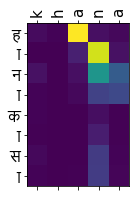

'हानाकासा\n'

In [ ]:
translate('khana')